# 1. Load Library

In [309]:
import pandas as pd
import numpy as np
np.random.seed(1234)
from sklearn import preprocessing
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)  

# 2. Data Processing

### Load Data

In [310]:
# load data, drop columns that are 'n/a'

data = [pd.read_csv(file, sep=' ', header=None) for file in ['data/train_FD001.txt','data/test_FD001.txt','data/RUL_FD001.txt']]
[f.drop(f.columns[[-1,-2]], axis=1, inplace=True) for f in data[0:2]]           # drop 'n/a' for test1/train1
data[2].drop(data[2].columns[[-1]], axis=1, inplace=True)                       # drop 'n/a' for test1/train1/rul1
header = ['id','cycle'] + ['setting'+str(i) for i in range(1,3+1)] + ['s'+str(j) for j in range(1,21+1)]
for k in range(2): data[k].columns = header

In [311]:
pd.DataFrame(np.array([[np.shape(dd)[0] for dd in data], [np.shape(ff)[1] for ff in data]]), index=['#columns', '#rows'], columns=['train','test','RUL'])

,train,test,RUL
#columns,20631,13096,100
#rows,26,26,1


### Create Labels

In [312]:
# training data
# add rul' (remaining useful life) = 'max' - 'cycle' for regression
# add w1, w2 for multi-class classification

w1, w2 = 30, 15
for item in data[0:1]:
    item['rul'] = item.groupby('id')['cycle'].transform('max') - item['cycle']
    item['w1'] = np.where(item['rul'] > w1, 0, 1)
    item['w2'] = np.where(item['rul'] > w2, 0, 1)
    item['w2'] = item['w2'] + item['w1']

In [313]:
# testing data
# add'rul' considers ground truth data from RUL_FD00*.txt, used for validation purpose
# handle ground truth data first

data[2].columns = ['truth']
data[2]['id'] = data[2].index + 1
for index in range(2):
    data[index] = data[index].merge(data[2], on=['id'], how='left')
    data[index]['rul'] = data[index].groupby('id')['cycle'].transform('max') + data[index]['truth'] - data[index]['cycle']
    data[index]['w1'] = np.where(data[index]['rul'] > w1, 0, 1)
    data[index]['w2'] = np.where(data[index]['rul'] > w2, 0, 1)
    data[index]['w2'] = data[index]['w2'] + data[index]['w1']
    data[index].drop(['truth'], axis = 1, inplace=True)

In [314]:
# assign to separate data sets for easier to manage

train, test, _ = data

In [378]:
train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul,w1,w2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,303,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,302,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,301,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,300,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,299,0,0


In [379]:
test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul,w1,w2
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0,0


### Time Series

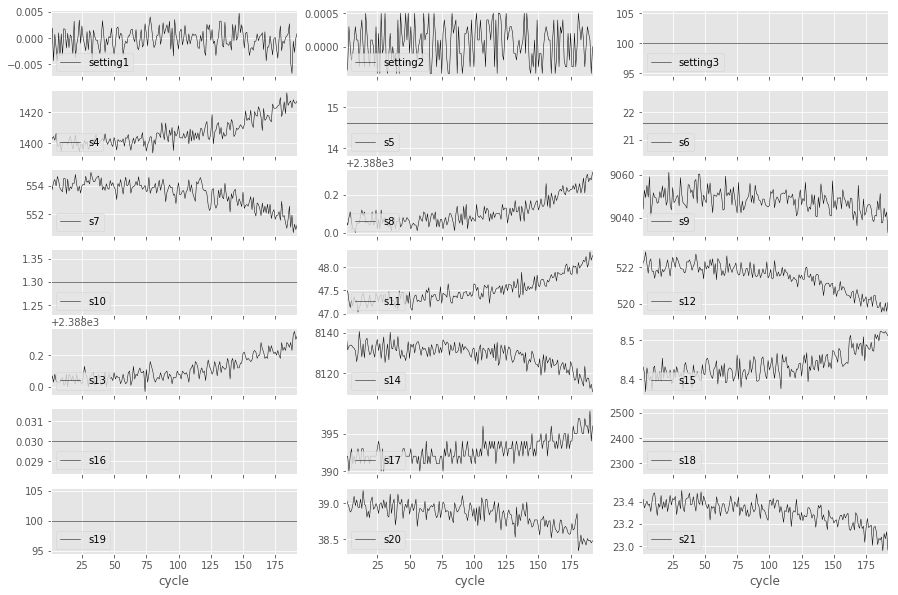

In [240]:
# look at one group of training sensor data over cycle time 

_, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
for index, ax in enumerate(axes.ravel()):
    if index in range(0,3):
        train[train['id']==1].plot(x='cycle', y = 'setting'+str(index+1), ax=ax, color='black', linewidth=0.5)
    else:
        train[train['id']==1].plot(x='cycle', y='s'+str(index+1), ax=ax, color='black', linewidth=0.5)
    ax.legend(loc='lower left')
plt.show()

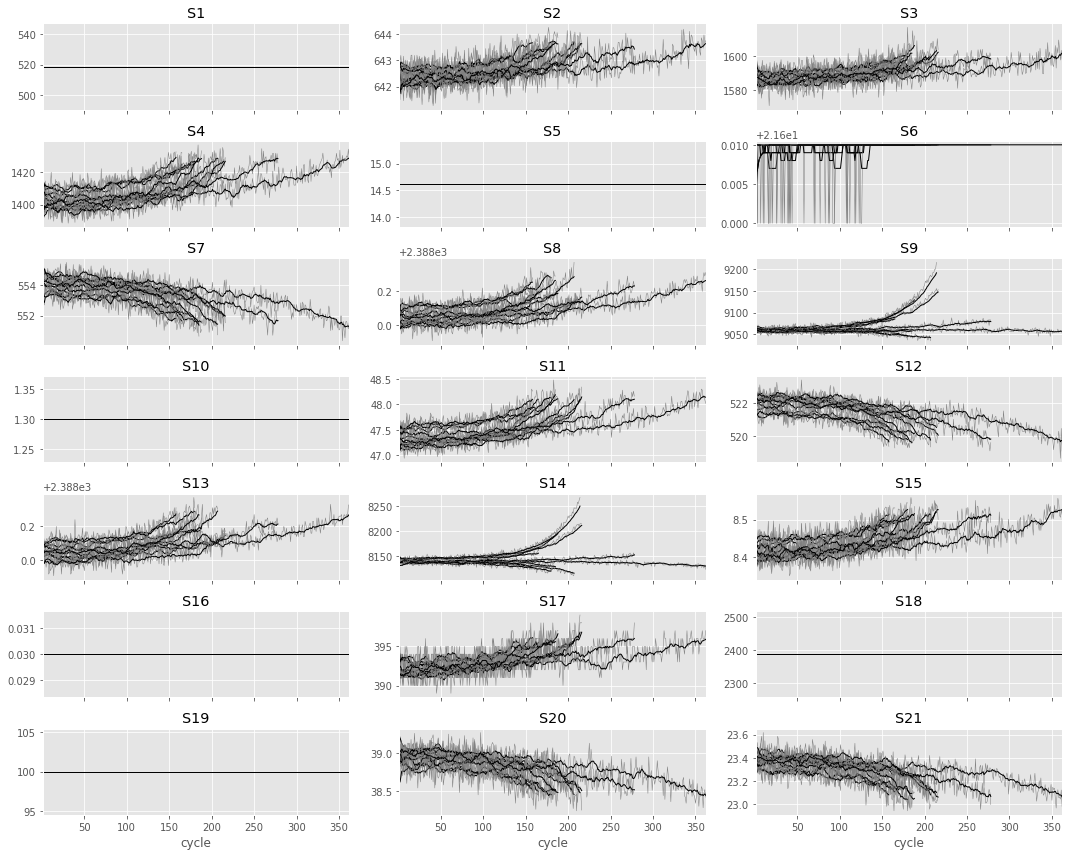

In [241]:
# Select 10 group to observe moving average

random10 = np.random.choice(train['id'].unique(), size=10, replace=False)
train_random10 = train[train['id'].isin(random10)].copy()

_, axes1 = plt.subplots(7, 3, figsize=(15, 12), sharex=True)
for index, ax in enumerate(axes1.ravel()):
    for unit_id, group in train_random10.groupby('id'):
        (group.plot(x='cycle', y='s'+str(index+1), ax=ax, color='gray', linewidth=0.5, legend=False))
        (group.rolling(window=10, on = 'cycle', min_periods=1)
             .mean().fillna(0)
             .plot(x='cycle', y='s'+str(index+1), ax=ax, color='black', linewidth=1, legend=False))
    ax.set_title(('s'+str(index+1)).title())
plt.tight_layout()
plt.show()

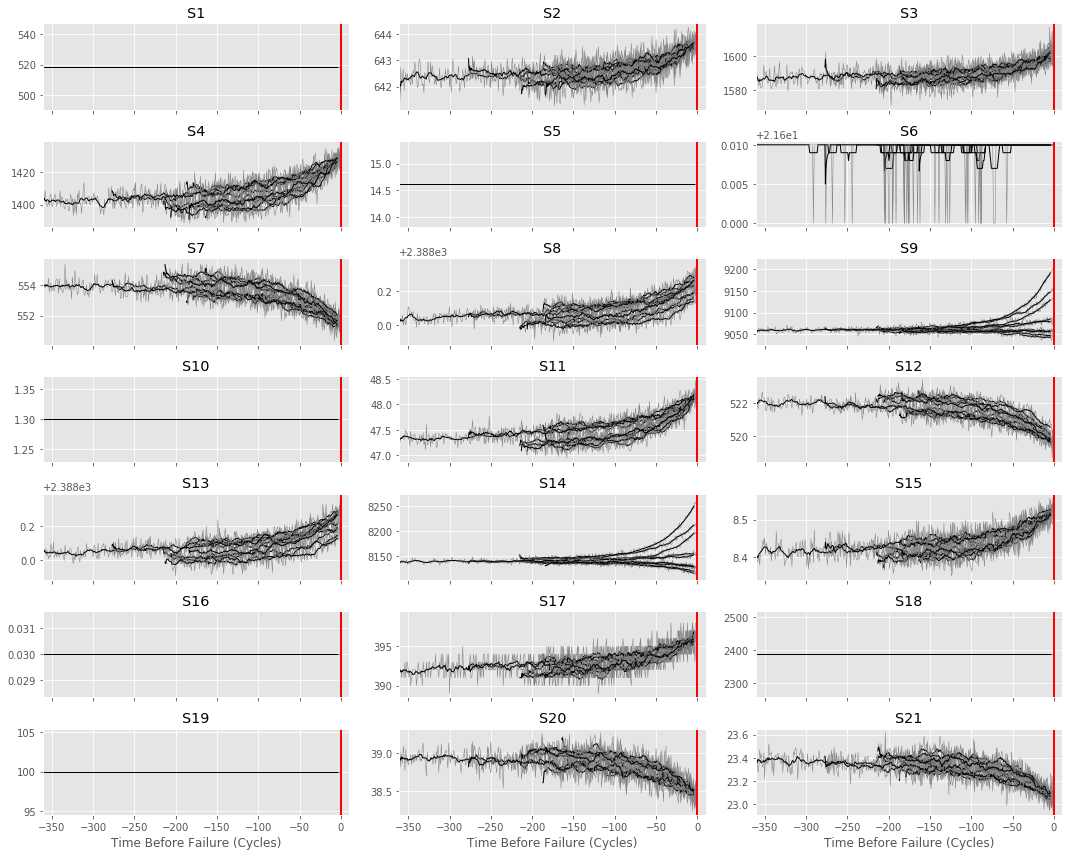

In [140]:
# Till end of life

d_plot = train_random10.copy()
d_plot['clf'] = train_random10.groupby('id')['rul'].transform('min') - d_plot['rul']
_, axes2 = plt.subplots(7, 3, figsize=(15, 12), sharex=True)
for index, ax in enumerate(axes2.ravel()):
    for unit_id, group in d_plot.groupby('id'):
        (group.plot(x='clf', y='s'+str(index+1), ax=ax, color='gray', linewidth=0.5, legend=False))
        (group.rolling(window=10, on = 'rul', min_periods=1)
             .mean().fillna(0)
             .plot(x='clf', y='s'+str(index+1), ax=ax, color='black', linewidth=1, legend=False))
    ax.set_title(('s'+str(index+1)).title())
    ax.set_xlabel("Time Before Failure (Cycles)");
    ax.axvline(x=0, color='r', linestyle='solid', linewidth=2)
    ax.set_xlim(d_plot['clf'].min(), 10)
plt.tight_layout()
plt.show()

### Normalization

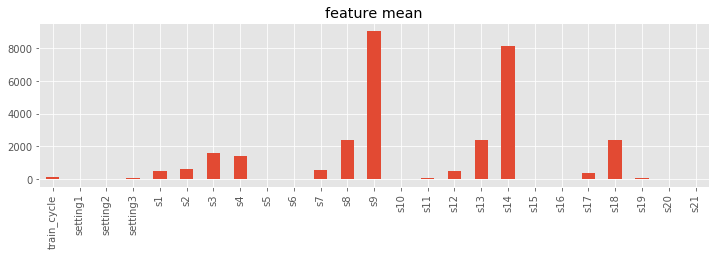

In [431]:
# the features are in quite different scales, makes sense to normalize

train_d[['train_cycle'] + feature].mean().plot(kind='bar', figsize=(12,3), title='feature mean')

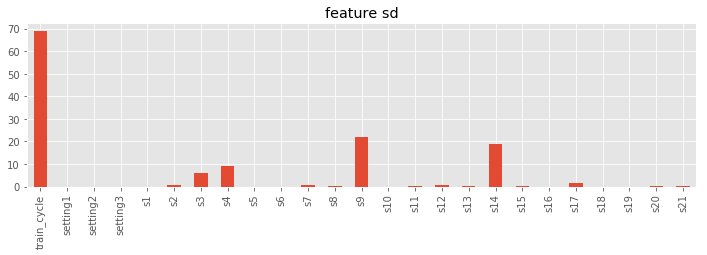

In [411]:
train_d[['train_cycle'] + feature].std().plot(kind='bar', figsize=(12,3), title='feature sd')